<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](img/churn.jpeg)

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de um projeto de data science - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados;
- Calculando estatísticas sobre o conjunto de dados;
- Visualização univariada;
- Visualizando multivariada;
- Pré-processamento. 


---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [2]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q holidays
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [3]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import multiprocessing
#import holidays

In [5]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import statsmodels.api   as sm
import dateutil.easter   as easter
import plotly.express    as px

In [6]:
import xgboost           as xgb

In [7]:
from sklearn.preprocessing    import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing    import PowerTransformer, RobustScaler, normalize
from sklearn.preprocessing    import MaxAbsScaler, QuantileTransformer, LabelEncoder

In [55]:
#from sklearn.compose            import ColumnTransformer, make_column_transformer
#from sklearn.pipeline           import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection  import VarianceThreshold
#from sklearn.impute             import SimpleImputer
#from scipy.stats                import chi2_contingency
#from plotly.subplots            import make_subplots

In [8]:
from datetime                 import datetime
from pylab                    import rcParams
#from matplotlib.ticker        import MaxNLocator, FormatStrFormatter, PercentFormatter
#from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
#from matplotlib.axes._axes    import _log as matplotlib_axes_logger
#from scipy.stats              import skew, norm
from datetime                 import timedelta

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [9]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
            
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

## 1.4. Dataset

O conjunto de dados de treinamento contém 4.250 amostras. Cada amostra inclui 19 features e 1 variável booleana “churn” indicando a classe da amostra. Os 19 recursos de entrada e 1 variável de destino são:

- <b>state</b>: Código de 2 letras do estado americano de residência do cliente;
- <b>account_length</b>: Número de meses que o cliente está com o provedor de telecomunicações atual;
- <b>area_code</b>: ”area_code_AAA” onde AAA = código de área de 3 dígitos;
- <b>international_plan</b>: indica se o cliente tem plano internacional;
- <b>voice_mail_plan</b>: indica se o cliente tem plano de correio de voz;
- <b>number_vmail_messages</b>: Número de mensagens de correio de voz ;
- <b>total_day_minutes</b>: Total de minutos de chamadas diárias;
- <b>total_day_calls</b>: Total de minutos de chamadas diárias;
- <b>total_day_charge</b>: Cobrança total das chamadas do dia
- <b>total_eve_minutes</b>: Total de minutos de chamadas noturnas; 
- <b>total_eve_calls</b>: Número total de chamadas noturnas;
- <b>total_eve_charge</b>: Cobrança total de chamadas noturnas;
- <b>total_night_minutes</b>: Total de minutos de chamadas noturnas; 
- <b>total_night_calls</b>: Número total de chamadas noturnas; 
- <b>total_night_charge</b>: Cobrança total das chamadas noturnas; 
- <b>total_intl_minutes</b>: Total de minutos de chamadas internacionais; 
- <b>total_intl_calls</b>: Número total de chamadas internacionais; 
- <b>total_intl_charge</b>: Cobrança total de chamadas internacionais; 
- <b>number_customer_service_calls</b>: Número de ligações para atendimento ao cliente; 
- <b>churn</b>: Perda de clientes — variável de destino (yes/no).


Este conjunto de dados é proveniente do [Kaggle Customer Churn Prediction 2020 Dataset](https://www.kaggle.com/competitions/customer-churn-prediction-2020/data).

### 1.4.2. Arquivos 
- <b>train.csv:</b> os dados de treinamento, que incluem a variável alvo(failure);
- <b>test.csv:</b> o conjunto de teste; a tarefa é prever a probabilidade de uma falha;
- <b>sample_submission.csv:</b> um arquivo de envio de amostra no formato correto

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [29]:
path        =  '/content/drive/MyDrive/Churn/Previsao de rotatividade de clientes/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'churn'

utility.create_fold(path)

In [30]:
df1_train     = pd.read_csv(path + 'Data/train.csv')
df1_test      = pd.read_csv(path + 'Data/test.csv')
df_submission = pd.read_csv(path + 'Data/sampleSubmission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((4250, 20), (750, 20), (750, 2))

In [31]:
df1_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [32]:
df1_test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.

## 2.1. Dimensão do DataSet

In [33]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

del df1_train, df1_test

In [34]:
print('TREINO')
print('Número de linhas : {}'.format(df2_train.shape[0]))
print('Número de colunas: {}'.format(df2_train.shape[1]))

print('TESTE')
print('Número de linhas : {}'.format(df2_test.shape[0]))
print('Número de colunas: {}'.format(df2_test.shape[1]))

TREINO
Número de linhas : 4250
Número de colunas: 20
TESTE
Número de linhas : 750
Número de colunas: 20


---

## 2.2. Tipo de dados

In [35]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [36]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')

=== For Pandas ==========
float64    8
int64      7
object     5
dtype: int64


---

In [42]:
feature_float = df2_test.select_dtypes(np.float64).columns.to_list() 
feature_int   = df2_test.select_dtypes(np.int64).columns.to_list() 
feature_cat   = df2_test.select_dtypes(object).columns.to_list() 
feature_int.remove('id')

In [46]:
for col in df2_train[feature_int]:       
    num_train = df2_train[col].unique().tolist()
    num_test  = df2_test[col].unique().tolist()
    
    num_train.sort()
    num_test.sort()
    
    #print('-'* 70)
    print('Feature: {}'.format(col))
    print('Train: {}\n'.format(num_train))    
    print('Test : {}'.format(num_test))    
    print('-'* 70)
    print()

Feature: account_length
Train: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 204, 208, 209, 210, 212, 215, 216, 217, 221, 222, 224, 225, 232, 243]



<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 

    
</div>

In [49]:
for col in df2_train[feature_cat ]:   
    num_train = df2_train[col].unique().tolist()
    num_test  = df2_test[col].unique().tolist()
    
    num_train.sort()
    num_test.sort()
    
    
    print('Feature: {}'.format(col))
    print('Train: {}\n'.format(num_train))    
    print('Test : {}'.format(num_test))    
    print('-'* 70)
    print()

Feature: state
Train: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

Test : ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
----------------------------------------------------------------------

Feature: area_code
Train: ['area_code_408', 'area_code_415', 'area_code_510']

Test : ['area_code_408', 'area_code_415', 'area_code_510']
----------------------------------------------------------------------

Feature: international_plan
Train: ['no', 'yes']

Test : ['no', 'yes']
---

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 

    
</div>

## 2.3. Identificar NA

In [37]:
missing = utility.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 20 colunas e 4250 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [38]:
missing = utility.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 20 colunas e 750 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não temos dados faltantes nos datasets. <p><br>
    
</div>

---

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [39]:
cmap= 'icefire_r'
display(df2_train.describe().T.style.background_gradient(cmap=cmap))  

,count,mean,std,min,25%,50%,75%,max
account_length,4250.000000,100.236235,39.698401,1.000000,73.000000,100.000000,127.000000,243.000000
number_vmail_messages,4250.000000,7.631765,13.439882,0.000000,0.000000,0.000000,16.000000,52.000000
total_day_minutes,4250.000000,180.259600,54.012373,0.000000,143.325000,180.450000,216.200000,351.500000
total_day_calls,4250.000000,99.907294,19.850817,0.000000,87.000000,100.000000,113.000000,165.000000
total_day_charge,4250.000000,30.644682,9.182096,0.000000,24.365000,30.680000,36.750000,59.760000
total_eve_minutes,4250.000000,200.173906,50.249518,0.000000,165.925000,200.700000,233.775000,359.300000
total_eve_calls,4250.000000,100.176471,19.908591,0.000000,87.000000,100.000000,114.000000,170.000000
total_eve_charge,4250.000000,17.015012,4.271212,0.000000,14.102500,17.060000,19.867500,30.540000
total_night_minutes,4250.000000,200.527882,50.353548,0.000000,167.225000,200.450000,234.700000,395.000000
total_night_calls,4250.000000,99.839529,20.093220,0.000000,86.000000,100.000000,113.000000,175.000000


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Observamos que as variáveis: <b>total_eve_charge, total_night_charge, total_intl_minutes, total_intl_calls, total_intl_charge e number_customer_service_calls</b>, são variáveis com baixa variância e provavelmente com baixa importância na modelagem.   <p> <br>
    
Vamos dar um olhada com gráfico de variância.<p><br>    
</div>

### 2.4.2. Gráfico de Variância

In [53]:
sns.set(style="darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor

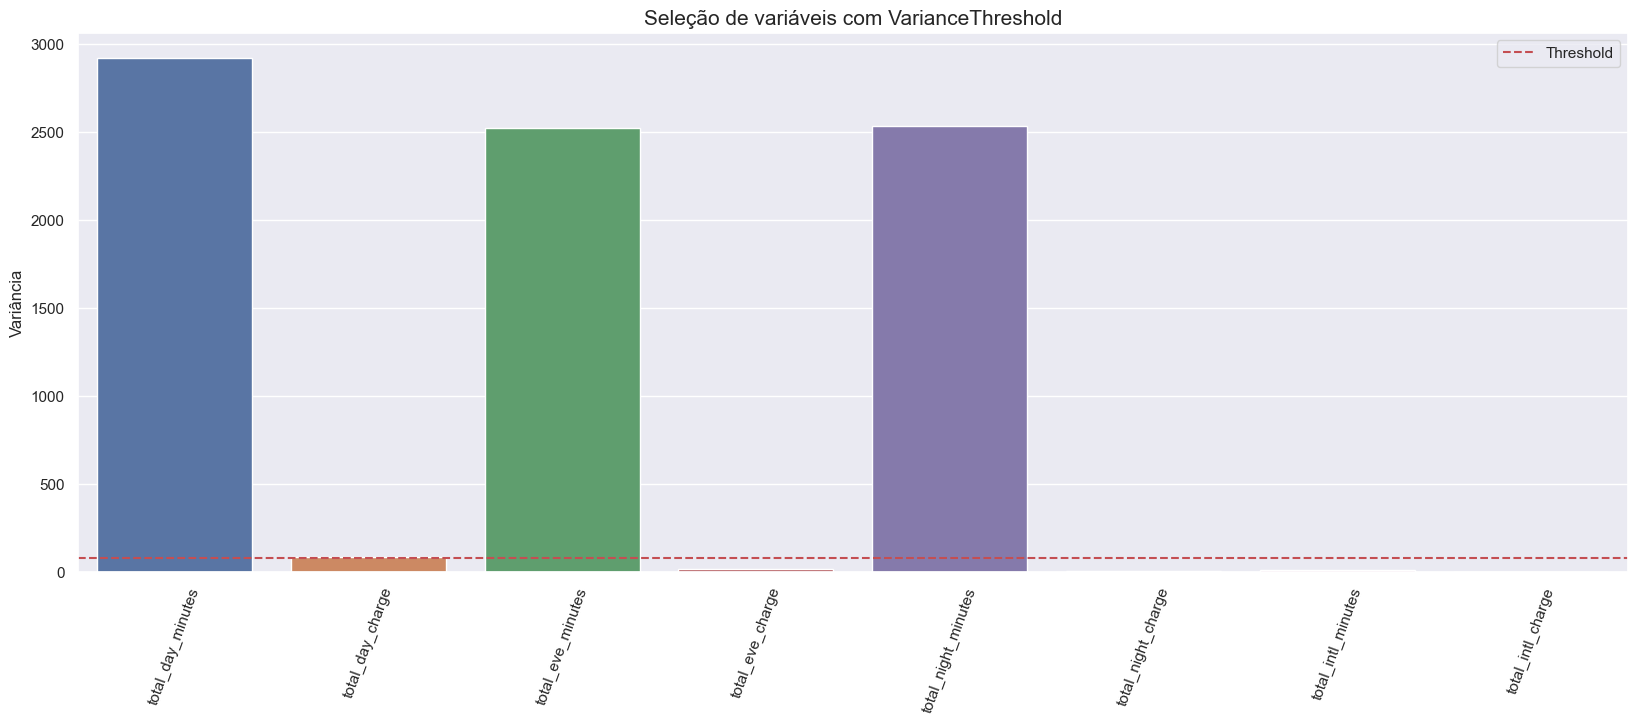

In [60]:
threshold = 80
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train[feature_float]
selector.fit_transform(df_aux)

plt.figure(figsize=(20,7))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')
plt.title('Seleção de variáveis com VarianceThreshold',size=15);
plt.ylabel('Variância');
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xticks(rotation=70)
plt.legend();

del df_aux

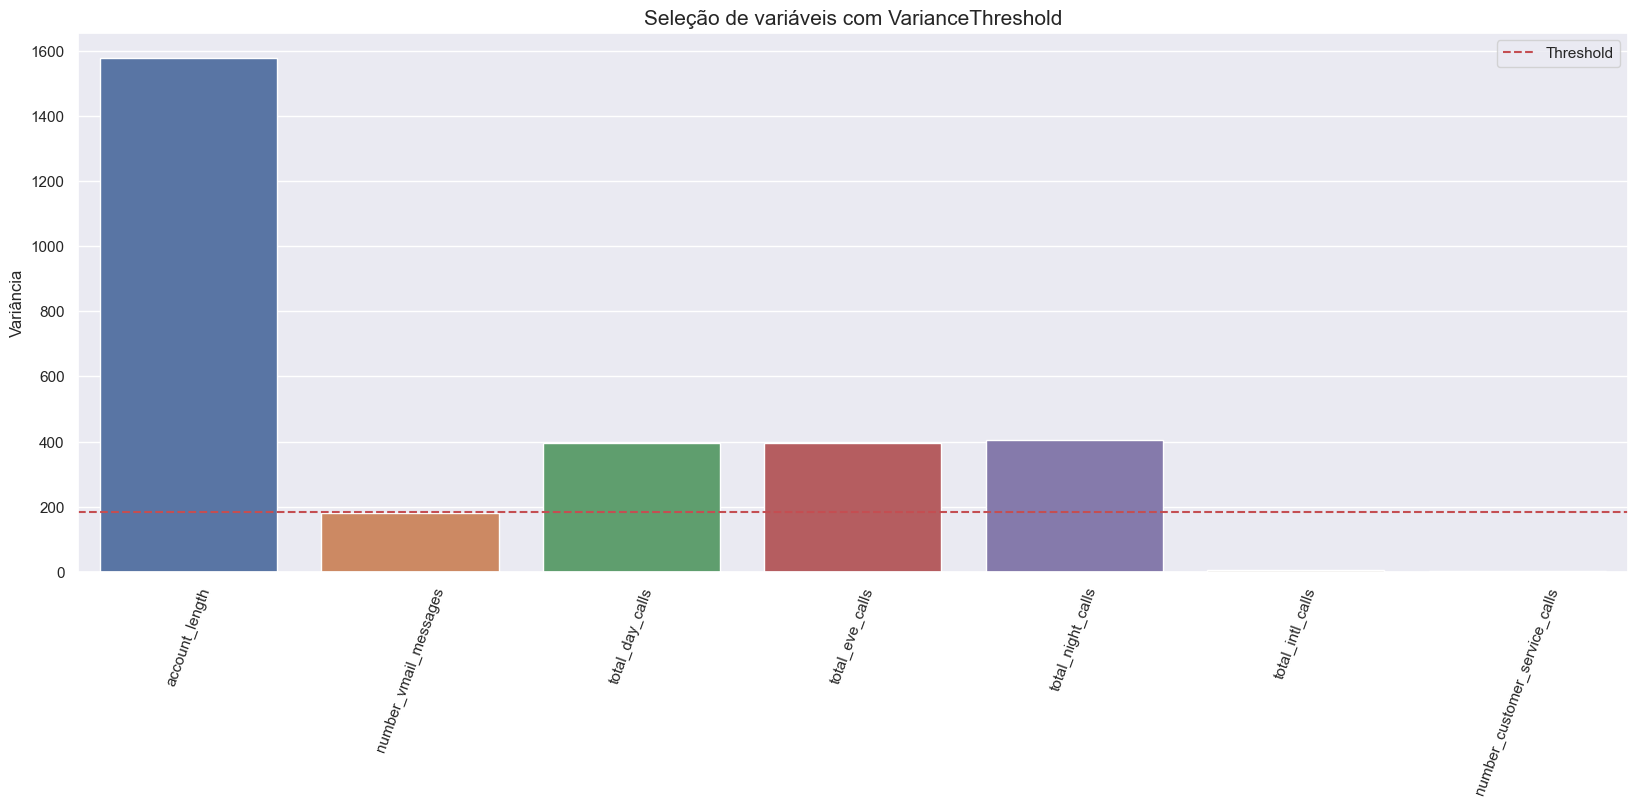

In [63]:
threshold = 185
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train[feature_int]
selector.fit_transform(df_aux)

plt.figure(figsize=(20,7))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')
plt.title('Seleção de variáveis com VarianceThreshold',size=15);
plt.ylabel('Variância');
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xticks(rotation=70)
plt.legend();

del df_aux

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   

</div>

---

## 2.6. Distribuição

### 2.6.1. Train / Test

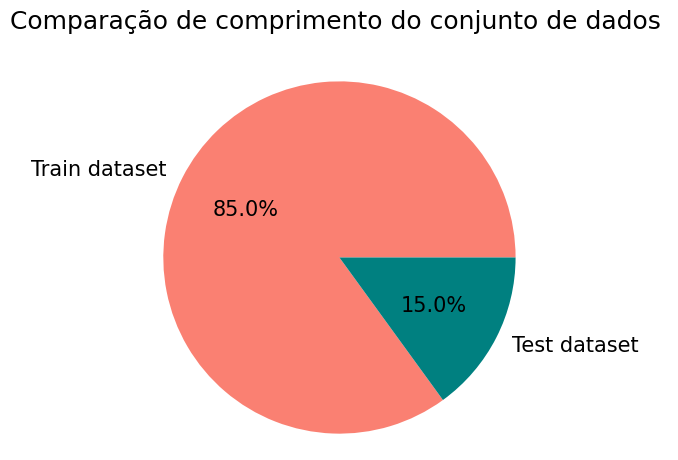

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

### 2.6.2. Distribuição da target

In [41]:
sns.set(style="darkgrid") 

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
     
Observando o gráfico acima, notamos que a distribuição dos dados não são normalmente distribuidos, segue uma distribuição assimétrica positiva com outliers acima de 500, uma sugestão é fazer uma normalização de log ou raiz quadrada, pode ajuda a resuzir a assemetria, a criação de uma variável para indicar se a amostra é um outlier ou não pode ajudar na modelagem, agora vamos fazer algumas transformações da variável alvo. <p> <br>
    
</div>

In [ ]:
# Churn 
- https://medium.com/@oxaichiko/customer-churn-analysis-a-case-study-on-the-telecommunication-industry-672211a53ed3
- https://jnyh.medium.com/customer-churn-classification-using-predictive-machine-learning-models-ab7ba165bf56 
